# GPX Activities Heatmap - Poster Generator
## Use this notebook to generator a high resolution heatmap of your Strava or other GPX activities.
### Author: Oliver Gladfelter
### Written: June 11, 2020; Last Updated: August 30, 2021

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import gpxpy
import gpxpy.gpx
import os
import random

%matplotlib inline

def load_run_data(gpx_path, filter=""):
    """ 
    paramater: gpx_path - a path to a folder full of gpx files
    returns a list of lists of parsed gpx data
    """

    # List all of the GPX files in the path
    gpx_files = glob.glob(os.path.join(gpx_path,filter+"*.gpx"))
    
    run_data = []
    
    # Loop through the files
    for file_idx, gpx_file in enumerate(gpx_files): 
        # Parse the GPX File
        try:
            gpx = gpxpy.parse(open(gpx_file, 'r'))
        except: 
            #os.remove(gpx_file)
            continue
         
        # gives us activity ID, gpx file path, latitude, longitude, elevation
        run_data_tmp = [[file_idx, gpx_file, point.latitude,point.longitude, point.elevation] 
                            for track in gpx.tracks 
                                for segment in track.segments 
                                    for point in segment.points]
        run_data += run_data_tmp
        
    return run_data


def computeActivityID(value):
    value = value.strip(folder_path + "/")
    return int(value.strip(".gpx"))

def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.values(): 
        spine.set_visible(False)
        
def plot_run_data(data, lineColor, lineOpacity, lineWidth, backgroundColor, outputFileName, minLat, maxLat, minLong, maxLong):
    """
    plots and saves an image of a heatmap
    params:
    - data: list of list or a dataframe, where each list or df row is GPS coordinates compiled in load_run_data()
    -lineColor: color of each GPX track
    -lineOpacity: how transparent each GPX track is
    -lineWidth: the stroke width for each GPX track
    -backgroundColor: color for heatmap's background, since we're not plotting on a traditional map
    -outputFileName: name of file heatmap image will be saved as 
    -minLat, maxLat, minLong, maxLong: dimensions for the map to help focus in on a specific area
    """
    coords_df = pd.DataFrame(data, columns=['Index','File_Name','Latitude','Longitude','Altitude'])  
    
    # print number of activities in the heatmap
    print(len(coords_df['Index'].unique()))
    
    # I used 80 x 80 for pictures I printed out into a 16" x 16" poster and it was perfect
    # you might need to mess around with these values for larger or bigger posters, and especially for non-square posters
    fig = plt.figure(figsize=(80,80)) 

    for num in coords_df['Index'].unique():
        run_coords = coords_df[coords_df['Index']==num]
        plt.plot(run_coords['Longitude'],run_coords['Latitude'], color=lineColor, linewidth=lineWidth, alpha=lineOpacity)

    ax = plt.gca()
    plt.grid(False)
    ax.patch.set_facecolor(backgroundColor)
    ax.set_aspect('auto','box','C')
    clear_frame()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=.1)
    
    # optional: if run_data contains activities from multiple cities, focus your heatmap on any
    # given city by setting the plot boundaries as the citie's min and max long and lat coordinates
    plt.xlim((minLong,maxLong))
    plt.ylim((minLat,maxLat))
    
    plt.savefig(output_file_name, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight', pad_inches=0,
        metadata=None)

# 0. Before we start, may I possibly save you some time by recommending https://cultureplot.com/strava-heatmap/?
# 1. Download your Strava data or collect all of your GPX files into a single folder
# 2. In the cell below, update the `folder_path` var to match the path from this .ipynb file to the folder containing your GPX files

In [ ]:
# `folder_path` is the path from this notebook to a folder full of GPX files
folder_path = "export_36833677//activities"

# Parse the gpx files and save data to a list of lists
activity_data = load_run_data(folder_path)

# validate the first list looks something like: [0, 'export_36833677//activities/5740599051.gpx', 41.925957, -87.638773, 182.8]
print(activity_data[0])

# 3. Optional step: filter down your activity data
### You can filter by activity type, date, lat and long range...anything in the `activities.csv` (if working with Strava data) or any meta data you may have from another source

In [33]:
# If working with data exported from Strava, your data export will have included an "activities.csv",
# which is full of metadata about the GPX files included in the data download

# read in activities.csv
meta_data = pd.read_csv("export_36833677//activities.csv")

# subset meta data to only to runs, in this example
meta_data = meta_data[meta_data['Activity Type']=='Run']

# convert activity_data to a dataframe for easy filtering
activity_data = pd.DataFrame(activity_data, columns=['Index','File_Name','Latitude','Longitude','Altitude'])

# simplify the values in file name column
activity_data['File_Name'] = activity_data['File_Name'].apply(computeActivityID)

# subset to only activities completed in a specific area range
#activity_data = activity_data[(activity_data['Latitude'] < 39.983434) & (activity_data['Latitude'] > 39.945809) & (activity_data['Longitude'] > -82.955461) & (activity_data['Longitude'] < -82.911426)]

# inner merge our two dataframes to remove non-run activities from activity_data
activity_data = activity_data.merge(meta_data, left_on="File_Name", right_on="Activity ID")
activity_data = activity_data[['Index','File_Name','Latitude','Longitude','Altitude']]

# 4. Now our data is ready for plotting! But first, we have some asthetic and design choices to make...

In [60]:
lineColor = '#FFFFFF' # stroke color
lineOpacity = 0.5 # stroke alpha value
lineWidth = 10 # stroke width
backgroundColor = '#001933' # we're not plotting on a normal map, because ~~art~~ 
output_file_name = 'heatmap.png' # save heatmap under this name

# these next few params are less design choices and more important for users with GPX files from multiple cities
# to prevent your map from looking like a blank canvas with some random dots on it, you'll want focus your heatmap on any
# given city by setting the plot boundaries as the city's min and max lat and long coordinates
min_lat = 40.647789
max_lat = 40.730217
min_long = -74.022393
max_long = -73.912763

# 5. Ta-da!

339


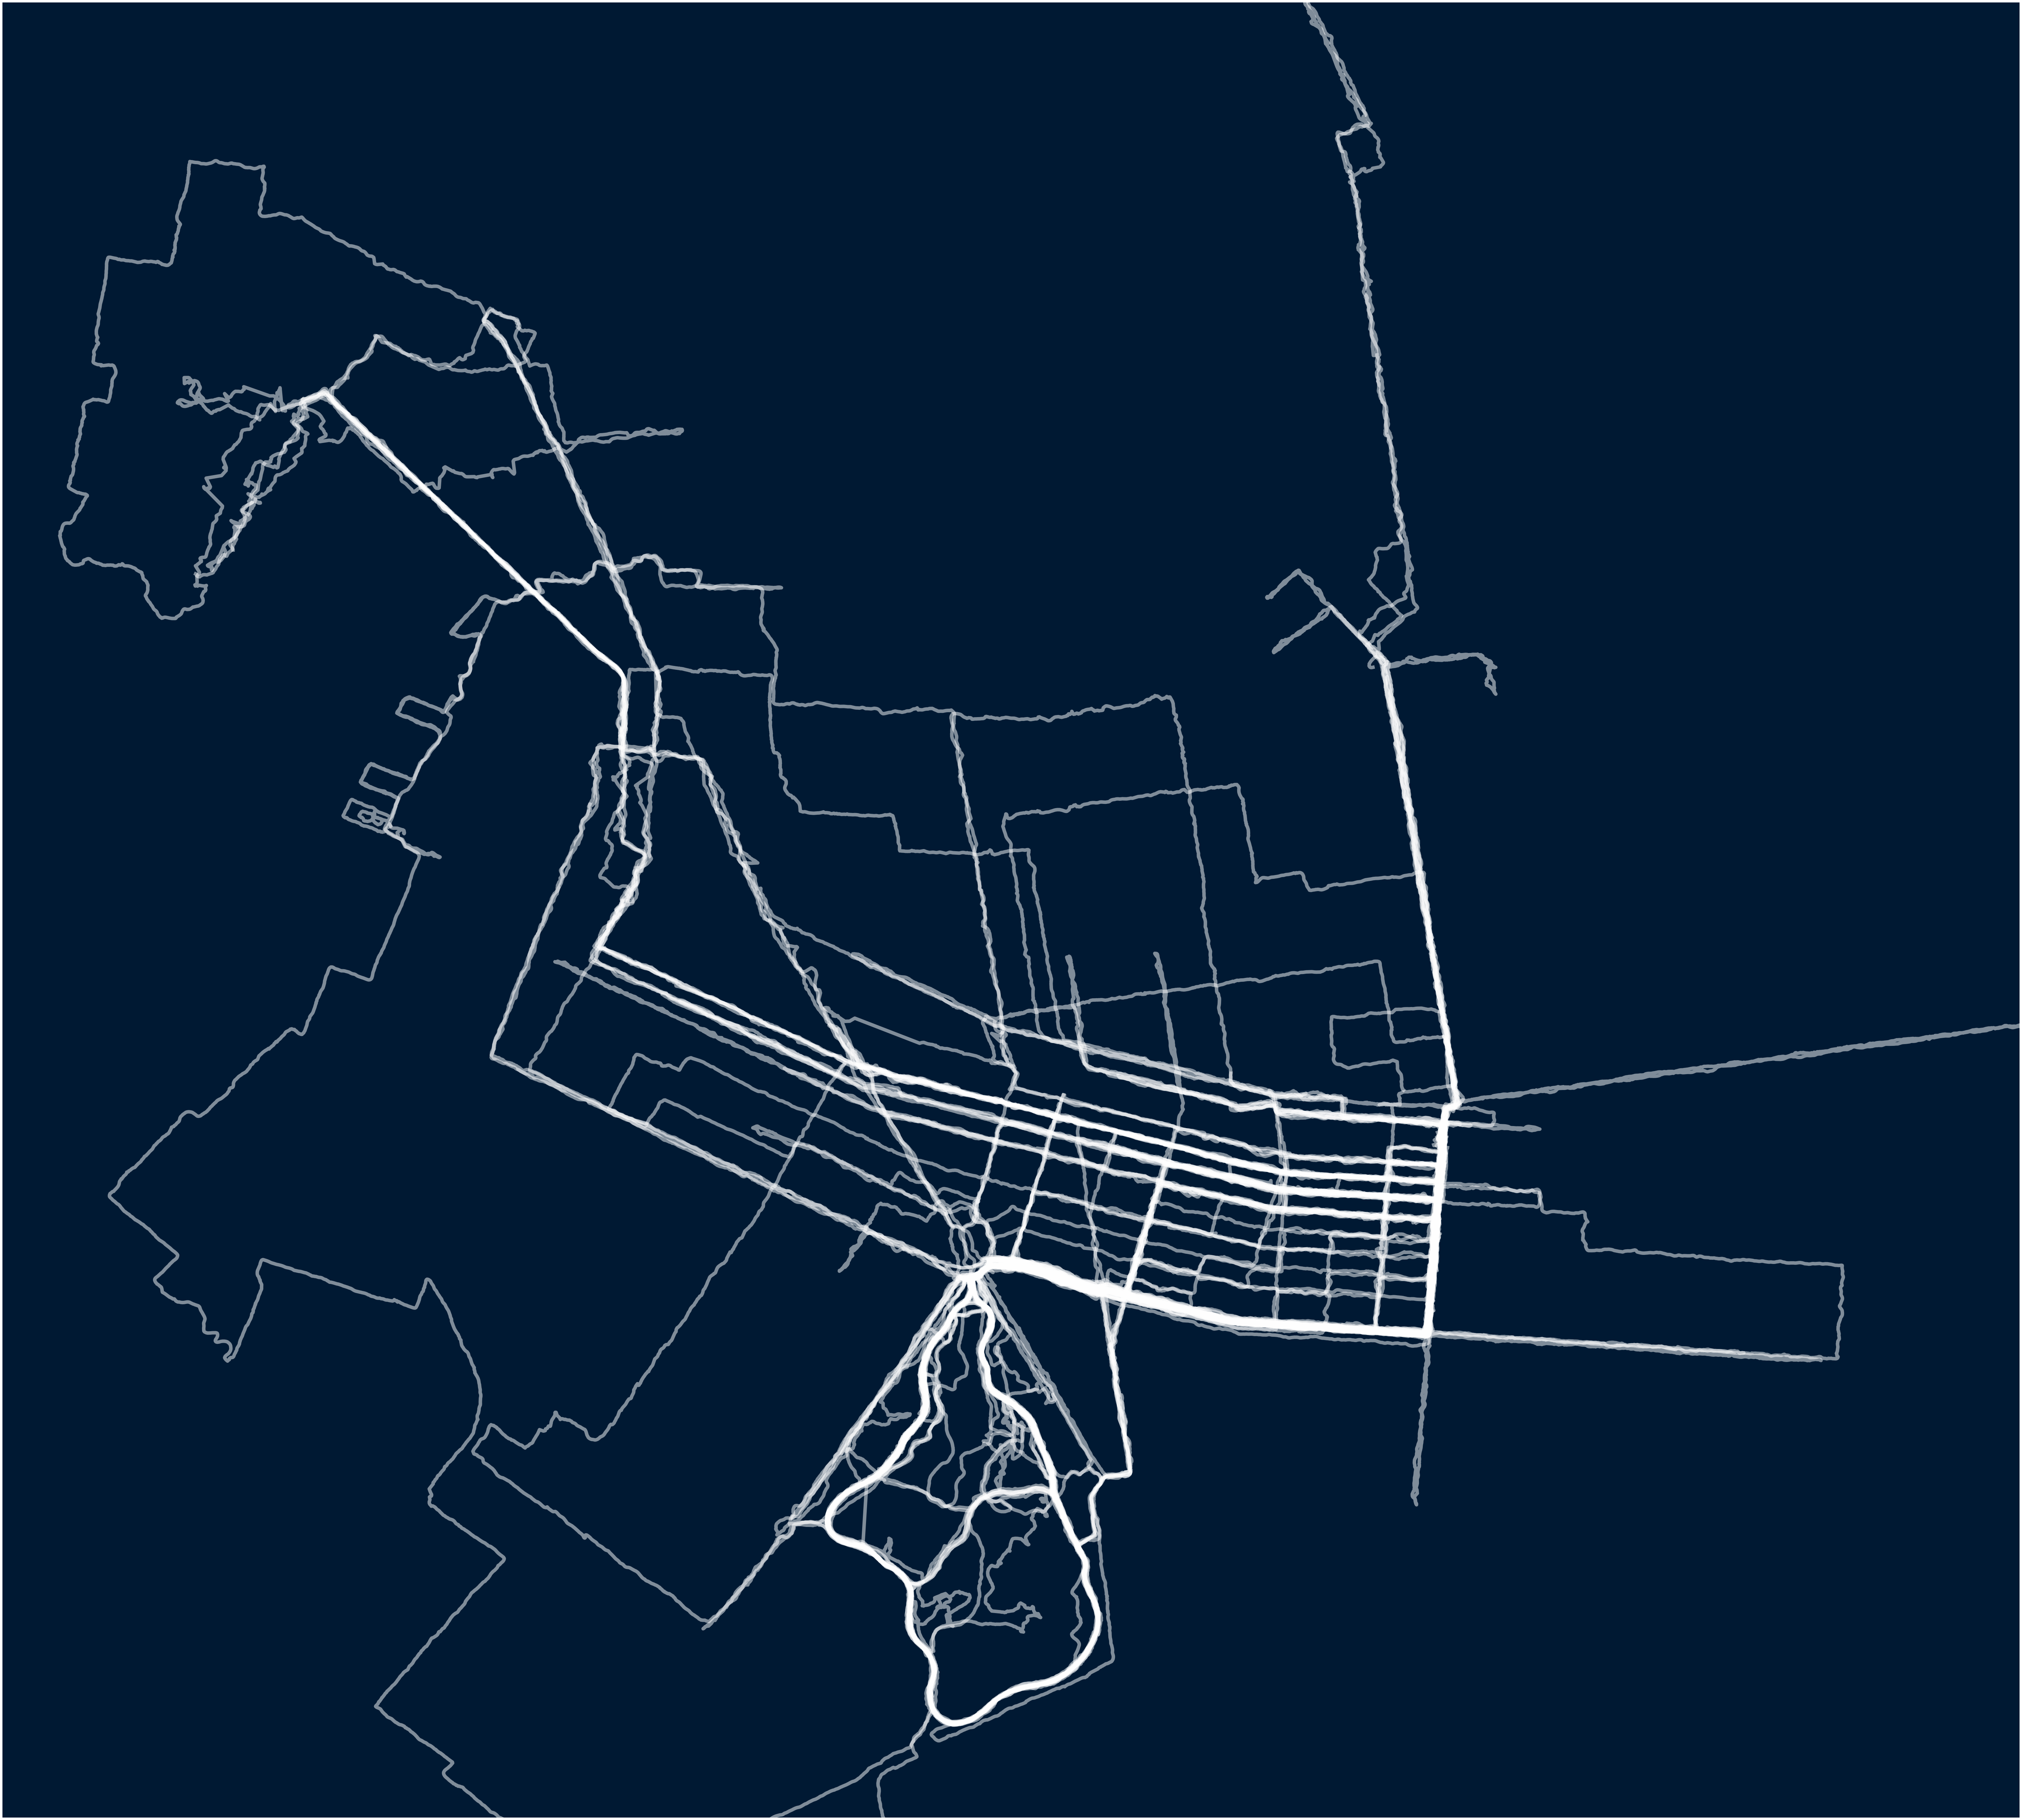

In [61]:
plot_run_data(activity_data, lineColor, lineOpacity, lineWidth, backgroundColor, output_file_name, min_lat, max_lat, min_long, max_long)

# 6. Optional last step: some added data privacy
### Are you planning on further using the data behind your heatmap for a public facing project? If so, this step can offset your coordinates by a random number for a layer of data privacy. This isn't 100% foolproof, but will make finding the exact start/end coordinates of your activities harder.

In [32]:
longtitude_offset = random.randrange(-100, 100)
latitude_offset = random.randrange(-100, 100)

activity_data['Longitude2'] = activity_data['Longitude'] + longtitude_offset
activity_data['Latitude2'] = activity_data['Latitude'] - latitude_offset

# just remember to remove the original 'Longitude' and 'Latitude' columns before using this data for anything public
activity_data.to_csv("offset_activity_data.csv", index=False)